# Throughput Test Report

## Experiment Environment

### Part 1: Server-based Experiment

<table>
  <tr>
    <th colspan="2"><b>Test Platform</b></th>
  </tr>
  <tr>
    <td><b>Ref Test Platform</b></td>
    <td>HP ProLiant DL360p Gen8 655651-B21</td>
  </tr>
  <tr>
    <td><b>CPU</b></td>
    <td>2x "IvyBridge" Intel® Xeon® E5-2630 v2 @ 2.6GHz</td>
  </tr>
  <tr>
    <td><b>Memory</b></td>
    <td>64GB DDR3</td>
  </tr>
  <tr>
    <td><b>Operating System</b></td>
    <td>Ubuntu 16.04.5</td>
  </tr>
  <tr>
    <td><b>Test SW</b></td>
    <td>fio-3.8</td>
  </tr>
  <tr>
    <td><b>HBA</b></td>
    <td>StarTech USB 3.0 Card PEXUSB3S24<br>Ugreen 20231 USB 3.0 to SATA Converter Adapter</td>
  </tr>
  <tr>
    <td><b>PCIe</b></td>
    <td>Gen 3.0</td>
  </tr>
</table>


<table>
  <tr>
    <th colspan="2"><b>Device Under Test</b></th>
  </tr>
  <tr>
    <td><b>Mfgr</b></td>
    <td>Toshiba HG6</td>
  </tr>
  <tr>
    <td><b>Model No.</b></td>
    <td>THNSNJ256G8NU</td>
  </tr>
  <tr>
    <td><b>S/N</b></td>
    <td>15NS100WT9JW</td>
  </tr>
  <tr>
    <td><b>Firmware Ver.</b></td>
    <td>JUGB0101</td>
  </tr>
  <tr>
    <td><b>Capacity</b></td>
    <td>256 GB</td>
  </tr>
  <tr>
    <td><b>Interface</b></td>
    <td>M.2 B-M<br></td>
  </tr>
  <tr>
    <td><b>NAND Type</b></td>
    <td>MLC</td>
  </tr>
  <tr>
    <td><b>Purge Method</b></td>
    <td>None</td>
  </tr>
  <tr>
    <td><b>Write Cache</b></td>
    <td>Enabled</td>
  </tr>
</table>


<table>
  <tr>
    <th colspan="2"><b>Set Up Parameters</b></th>
  </tr>
  <tr>
    <td><b>Active Range</b></td>
    <td>75%<br></td>
  </tr>
  <tr>
    <td><b>Pre Condition 1</b></td>
    <td>SEQ 128KiB W</td>
  </tr>
  <tr>
    <td>    TOIO - TC/QD</td>
    <td>TC 1 / QD 32</td>
  </tr>
  <tr>
    <td>    Duration</td>
    <td>2 x User Capacity</td>
  </tr>
  <tr>
    <td><b>Pre Condition 2</b></td>
    <td>SEQ 1024KiB W</td>
  </tr>
  <tr>
    <td>    TOIO - TC/QD</td>
    <td>TC 1 / QD 32<br></td>
  </tr>
  <tr>
    <td>    Duration</td>
    <td>2 x User Capacity</td>
  </tr>
  <tr>
    <td><b>Purge Method</b></td>
    <td>None</td>
  </tr>
  <tr>
    <td><b>Write Cache</b></td>
    <td>Enabled</td>
  </tr>
</table>


<table>
  <tr>
    <th colspan="2"><b>Test Parameters</b></th>
  </tr>
  <tr>
    <td><b>Active Range</b></td>
    <td>75%</td>
  </tr>
  <tr>
    <td><b>Test Stimulus 1</b></td>
    <td>SEQ</td>
  </tr>
  <tr>
    <td>    R/W Mix</td>
    <td>100:0 / 0:100</td>
  </tr>
  <tr>
    <td>    Block Size</td>
    <td>128KiB / 1024KiB</td>
  </tr>
  <tr>
    <td>    TOIO - TC/QD</td>
    <td>TC 1 / QD 32</td>
  </tr>
  <tr>
    <td>    Steady State</td>
    <td>1 - 5</td>
  </tr>
</table>

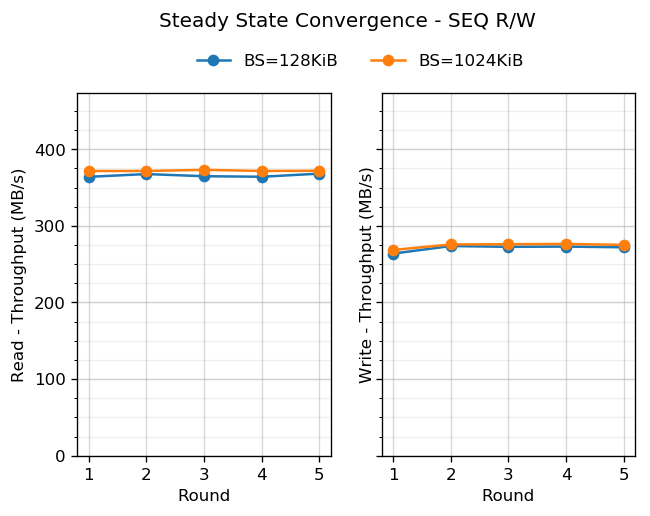

---

Measurement Window,1 - 5
Ave. value in Measurement Window,365.813 MiB/s
Calculated allowed range in Measurement Window (+-10% of Ave.),402.394 MiB/s (Max) / 329.232 MiB/s (Min)
Measured range in Measurement Window,368.254 MiB/s (Max) / 364.070 MiB/s (Min) (pass)
Slope of best linear fit in Measurement Window (must be <= 10%),0.265% (pass)
Least Squares Linear Fit Formula,0.4844 x + 364.4


Measurement Window,1 - 5
Ave. value in Measurement Window,372.070 MiB/s
Calculated allowed range in Measurement Window (+-10% of Ave.),409.277 MiB/s (Max) / 334.863 MiB/s (Min)
Measured range in Measurement Window,373.181 MiB/s (Max) / 371.698 MiB/s (Min) (pass)
Slope of best linear fit in Measurement Window (must be <= 10%),0.030% (pass)
Least Squares Linear Fit Formula,0.05661 x + 371.9


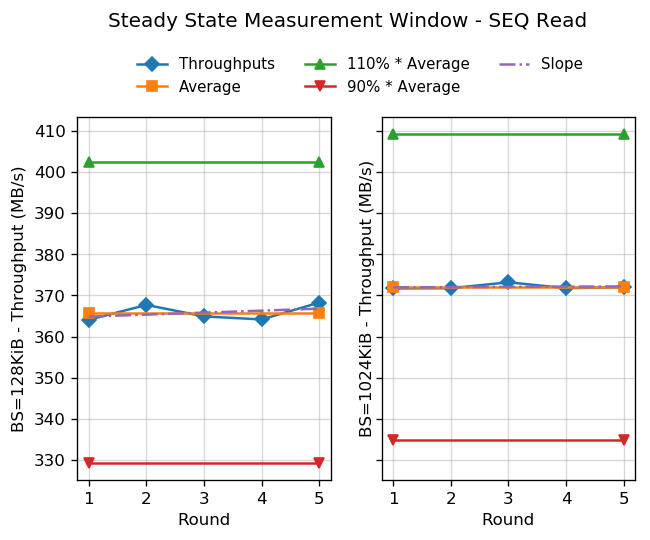

---

Measurement Window,1 - 5
Ave. value in Measurement Window,271.064 MiB/s
Calculated allowed range in Measurement Window (+-10% of Ave.),298.170 MiB/s (Max) / 243.957 MiB/s (Min)
Measured range in Measurement Window,273.703 MiB/s (Max) / 263.849 MiB/s (Min) (pass)
Slope of best linear fit in Measurement Window (must be <= 10%),1.163% (pass)
Least Squares Linear Fit Formula,1.576 x + 266.3


Measurement Window,1 - 5
Ave. value in Measurement Window,274.416 MiB/s
Calculated allowed range in Measurement Window (+-10% of Ave.),301.857 MiB/s (Max) / 246.974 MiB/s (Min)
Measured range in Measurement Window,276.423 MiB/s (Max) / 268.616 MiB/s (Min) (pass)
Slope of best linear fit in Measurement Window (must be <= 10%),1.014% (pass)
Least Squares Linear Fit Formula,1.391 x + 270.2


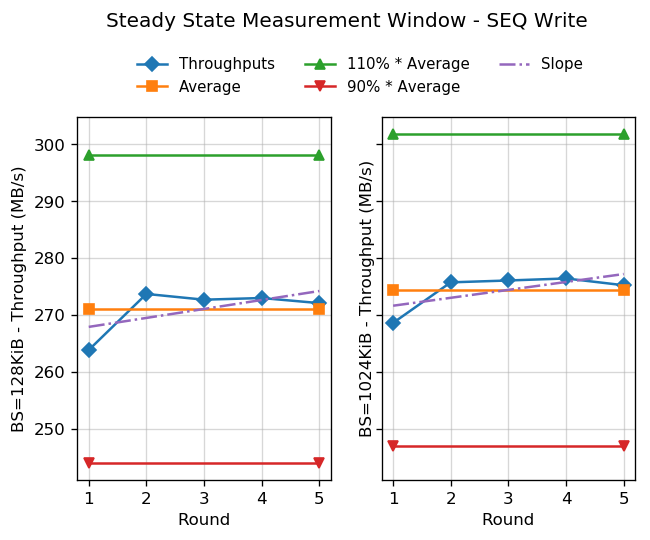

---

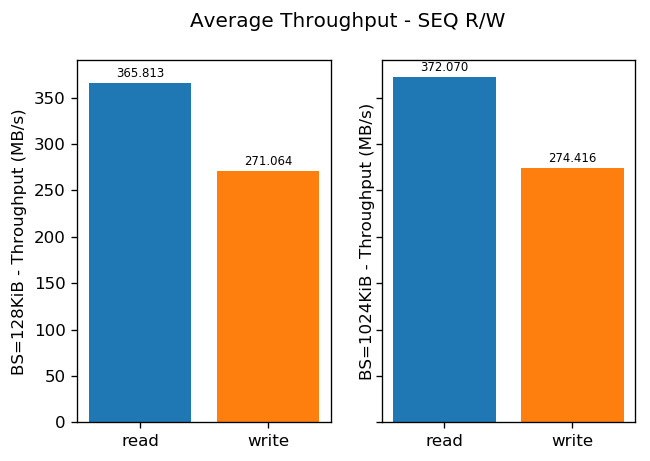

In [2]:
from IPython.display import display, Markdown, HTML

import matplotlib.pyplot as plt
import numpy as np

import glob
import json
import re


DATA_DIR = '../data/'


def __get_profiles(profiles_dirname, bs, pread):
    """Return all profiles matching the block size and pread.
    
    Args:
        bs (str): The number of block size in KiB.
        pread (int): The percentage of read in R/W mix. (Must be either 100 or 0)
    
    """
    profile_name_pattern = '/wdpc_bs{:s}kB_read{:d}_round[0-9]*.json'.format(bs, pread)
    profiles = sorted(glob.glob(DATA_DIR + profiles_dirname + profile_name_pattern))
    
    if not profiles:
        raise RuntimeError('Cannot find any profiles with pattern %r' %  profile_name_pattern)
    
    rounds = list(map(lambda s : int(re.search(r'round(\d+)', s).group(1)), profiles))

    return rounds, profiles


def __get_job_obj(profile):
    """Return the 'job' object in the profile."""
    with open(profile, 'rt') as json_fobj:
        data = json.load(json_fobj)
    
    return data['jobs'][0]


def __get_num_in(profile, key_path):
    """Return the value pointed by the key path in the profile."""
    job = __get_job_obj(profile)
    
    obj = job
    for key in key_path:
        obj = obj[key]
        
    return obj


def __get_bw_means(profiles_dirname, bs, mode):
    """Get all bw_means in profiles matching the block size and mode.
    
    Args:
        profiles_dirname (str): The name of the profile folder.
        bs (str): The number of block size in KiB.
        mode (str): Must be either 'read' or 'write'.
    
    """
    if 'read' == mode:
        pread = 100
    elif 'write' == mode:
        pread = 0
    else:
        raise RuntimeError("mode must be either 'read' or 'write'")

    values = []
    rounds, profiles = __get_profiles(profiles_dirname, bs, pread)
    for profile in profiles:
        bw_mb = __get_num_in(profile, [mode, 'bw_mean']) / 1024
        values.append(bw_mb)
        
    return rounds, values


FIG_DPI = 120


def __create_subplots():
    fig, axes = plt.subplots(1, len(MODES), sharey='row')
    
    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(FIG_DPI)
    
    return fig, axes


MODES = ['read', 'write']
BLOCK_SIZES = ['128', '1024']


def plot_ss_convergence(profiles_dirname):
    fig, axes = __create_subplots()
    
    ymax = 0
    for idx, mode in enumerate(MODES):
        ax = axes[idx]
        
        bars = []
        for bs in BLOCK_SIZES:
            rounds, values = __get_bw_means(profiles_dirname, bs, mode)
            bars.append(ax.errorbar(rounds, values, fmt='-o'))
        
        cur_ymax = max(values) + 100
        if cur_ymax > ymax:
            ymax = cur_ymax
            ax.set_yticks(np.arange(0, ymax, 25), minor=True)
            ax.set_ylim(ymin=0, ymax=ymax)
        
        ax.grid(which='both', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        ax.set_ylabel(mode.capitalize() + ' - Throughput (MB/s)')
        ax.set_xlabel('Round')
    
    plt.figlegend(
            bars,
            ['BS=' + bs + 'KiB' for bs in BLOCK_SIZES],
            loc=8,
            bbox_to_anchor=(0.5, 0.9),
            frameon=False,
            ncol=2)
    plt.suptitle('Steady State Convergence - SEQ R/W', y=1.05)
    plt.show()
    

MEASUREMENT_WINDOW_SIZE = 5
EXCURSION_THRESHOLD = 0.1
EXCURSION_UP = 1 + EXCURSION_THRESHOLD
EXCURSION_DOWN = 1 - EXCURSION_THRESHOLD


def plot_ss_measurement_window(profiles_dirname):
    for mode in MODES:
        display(Markdown('---'))
        fig, axes = __create_subplots()

        for idx, bs in enumerate(BLOCK_SIZES):
            ax = axes[idx]
            
            bars = []
            
            rounds, values = __get_bw_means(profiles_dirname, bs, mode)
            
            # get the values and rounds within the measurement window
            rounds_in_window = rounds[-1 * MEASUREMENT_WINDOW_SIZE:]
            values_in_window = values[-1 * MEASUREMENT_WINDOW_SIZE:]
            
            # plot throughputs
            bars.append(ax.errorbar(rounds, values, fmt='-D'))
            
            # plot average lines
            avg_value = np.mean(values_in_window)
            times_to_shape = {1: '-s', EXCURSION_UP: '-^', EXCURSION_DOWN: '-v'}
            
            for time, shape in times_to_shape.items():
                bars.append(
                    ax.errorbar(
                        [rounds_in_window[0], rounds_in_window[-1]],
                        [avg_value * time] * 2,
                        fmt=shape)
                )
            
            # plot slope line
            coefficients = np.polyfit(rounds_in_window, values_in_window, 1)
            poly = np.poly1d(coefficients)
            bars.append(
                ax.errorbar(
                    rounds_in_window,
                    poly(rounds_in_window),
                    fmt='-.')
            )
            
            ax.grid(which='major', alpha=0.5)
            
            ax.set_ylabel('BS=' + bs + 'KiB' + ' - Throughput (MB/s)')
            ax.set_xlabel('Round')
            
            verification_report = '''\
            <table>
              <caption><b>Block Size: {bs}KiB</b></caption>
              <tr>
                <td><b>Measurement Window</b></td>
                <td>{start} - {end}</td>
              </tr>
              <tr>
                <td><b>Ave. value in Measurement Window</b></td>
                <td>{avg:.3f} MiB/s</td>
              </tr>
              <tr>
                <td><b>Calculated allowed range in Measurement Window (+-10% of Ave.)</b></td>
                <td>{excursion_up_val:.3f} MiB/s (Max) / {excursion_down_val:.3f} MiB/s (Min)</td>
              </tr>
              <tr>
                <td><b>Measured range in Measurement Window</b></td>
                <td>{max_val:.3f} MiB/s (Max) / {min_val:.3f} MiB/s (Min)  (<b>pass</b>)</td>
              </tr>
              <tr>
                <td><b>Slope of best linear fit in Measurement Window (must be &lt;= 10%)</b></td>
                <td>{max_excursion_percentage:.3f}% (<b>pass</b>)</td>
              </tr>
              <tr>
                <td><b>Least Squares Linear Fit Formula</b></td>
                <td>{formula}</td>
              </tr>
            </table><br/>\
            '''.format(
                bs=bs,
                start=rounds_in_window[0],
                end=rounds_in_window[-1],
                avg=avg_value,
                excursion_up_val=avg_value * EXCURSION_UP,
                excursion_down_val = avg_value * EXCURSION_DOWN,
                max_val=max(values_in_window),
                min_val=min(values_in_window),
                max_excursion_percentage=100 * max(abs(1 - poly(rounds_in_window[0]) / avg_value),
                                                   abs(1 - poly(rounds_in_window[-1]) / avg_value)),
                formula=poly)
            display(HTML(verification_report))
        
        plt.figlegend(
                bars,
                ['Throughputs', 'Average', '110% * Average', '90% * Average', 'Slope'],
                loc=8,
                bbox_to_anchor=(0.5, 0.9),
                frameon=False,
                ncol=3,
                prop={'size': 9})
        plt.suptitle('Steady State Measurement Window - SEQ ' + mode.capitalize(), y=1.1)
        plt.show()


def plot_tp_measurement(profiles_dirname):
    display(Markdown('---'))
    fig, axes = __create_subplots()
    for idx, bs in enumerate(BLOCK_SIZES):
        ax = axes[idx]
            
        bars = []
        
        for mode in MODES:
            rounds, values = __get_bw_means(profiles_dirname, bs, mode)
            values_in_window = values[-1 * MEASUREMENT_WINDOW_SIZE:]
            avg_value = np.mean(values_in_window)
            
            bars.append(ax.bar(mode, avg_value))
            ax.text(
                mode,
                avg_value * 1.01,
                '{:.3f}'.format(avg_value),
                fontsize=7,
                ha='center',
                va='bottom')

        ax.set_ylabel('BS=' + bs + 'KiB' + ' - Throughput (MB/s)')
            
    plt.suptitle('Average Throughput - SEQ R/W')


profiles_dirname = 'usb3_throughput'

plot_ss_convergence(profiles_dirname)
plot_ss_measurement_window(profiles_dirname)
plot_tp_measurement(profiles_dirname)

## Notes

### Definition of ***Steady State***

```
A device is said to be in Steady State when, for the dependent variable (y)
being tracked:
    a) Range(y) is less than 10% of Ave(y): Max(y)-Min(y) within the
       Measurement Window is no more than 10% of the Ave(y) within the
       Measurement Window; and
    b) Slope(y) is less than 10%: Max(y)-Min(y), where Max(y) and Min(y) are
       the maximum and minimum values on the best linear curve fit of the
       y-values within the Measurement Window, is within 10% of Ave(y) value
       within the Measurement Window.
```

## References

- [Solid State Storage (SSS) Performance Test Specification (PTS) v2.0.1](https://www.snia.org/sites/default/files/technical_work/PTS/SSS_PTS_2.0.1.pdf)